In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.0302

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 607ms/step - loss: 0.0240
Average validation loss: 0.10285980999469757
4/4 [==============================] - 6s 621ms/step - loss: 0.0240 - val_loss: 0.1029
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 631ms/step - loss: 0.0184 - val_loss: 0.1029
Average validation loss: 0.10255961865186691
4/4 [==============================] - 8s 642ms/step - loss: 0.0184 - val_loss: 0.1027
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 624ms/step - loss: 0.0139 - val_loss: 0.1027
Average validation loss: 0.08072635531425476
4/4 [==============================] - 11s 638ms/step - loss: 0.0139 - val_loss: 0.0954
Saved model weights to 'c:\Users\user\Desktop\

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 701ms/step - loss: 0.0011
Average validation loss: 0.015870481729507446
8/8 [==============================] - 6s 715ms/step - loss: 0.0011 - val_loss: 0.0159
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 708ms/step - loss: 0.0010 - val_loss: 0.0159
Average validation loss: 0.11185004934668541
8/8 [==============================] - 12s 722ms/step - loss: 0.0010 - val_loss: 0.0639
Epoch 3/10
8/8 [==============================] - 17s 704ms/step - loss: 0.0010 - val_loss: 0.0639
Average validation loss: 0.16109615564346313
8/8 [==============================] - 17s 717ms/step - loss: 0.0010 - val_loss: 0.0963
Epoch 4/10
8/8 [==============================] - 23s 704ms/step - loss: 0.0010 - val_loss: 0.0963
Average validation loss: 0.1644599437713623
8/8 [==============================] - 23s 71

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 718ms/step - loss: 0.0012
Average validation loss: 0.05084505428870519
12/12 [==============================] - 9s 728ms/step - loss: 0.0012 - val_loss: 0.0508
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 724ms/step - loss: 0.0012 - val_loss: 0.0508
Average validation loss: 0.08750795821348827
12/12 [==============================] - 18s 736ms/step - loss: 0.0012 - val_loss: 0.0692
Epoch 3/10
12/12 [==============================] - 27s 735ms/step - loss: 0.0012 - val_loss: 0.0692
Average validation loss: 0.05802484477559725
12/12 [==============================] - 27s 746ms/step - loss: 0.0012 - val_loss: 0.0655
Epoch 4/10
12/12 [==============================] - 35s 706ms/step - loss: 0.0011 - val_loss: 0.0655
Average validation loss: 0.14112089077631632
12/12 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 733ms/step - loss: 8.7337e-04
Average validation loss: 0.12022179365158081
16/16 [==============================] - 12s 745ms/step - loss: 8.7337e-04 - val_loss: 0.1202
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 728ms/step - loss: 8.3198e-04 - val_loss: 0.1202
Average validation loss: 0.12263857200741768
16/16 [==============================] - 24s 742ms/step - loss: 8.3198e-04 - val_loss: 0.1214
Epoch 3/10
16/16 [==============================] - 35s 714ms/step - loss: 8.2092e-04 - val_loss: 0.1214
Average validation loss: 0.07702957279980183
16/16 [==============================] - 35s 728ms/step - loss: 8.2092e-04 - val_loss: 0.1066
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_20.pth'.
Epoc

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 743ms/step - loss: 5.8590e-04
Average validation loss: 0.07999945431947708
20/20 [==============================] - 15s 754ms/step - loss: 5.8590e-04 - val_loss: 0.0800
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 30s 722ms/step - loss: 5.7988e-04 - val_loss: 0.0800
Average validation loss: 0.10385610312223434
20/20 [==============================] - 30s 734ms/step - loss: 5.7988e-04 - val_loss: 0.0919
Epoch 3/10
20/20 [==============================] - 44s 720ms/step - loss: 5.7145e-04 - val_loss: 0.0919
Average validation loss: 0.1201698675751686
20/20 [==============================] - 44s 731ms/step - loss: 5.7145e-04 - val_loss: 0.1013
Epoch 4/10
20/20 [==============================] - 59s 718ms/step - loss: 5.5654e-04 - val_loss: 0.1013
Average validation loss: 0.11049358695745468
20

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 716ms/step - loss: 5.9612e-04
Average validation loss: 0.10106608147422473
24/24 [==============================] - 17s 727ms/step - loss: 5.9612e-04 - val_loss: 0.1011
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 715ms/step - loss: 5.7110e-04 - val_loss: 0.1011
Average validation loss: 0.08531140784422557
24/24 [==============================] - 35s 727ms/step - loss: 5.7110e-04 - val_loss: 0.0932
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 714ms/step - loss: 5.2577e-04 - val_loss: 0.0932
Average validation loss: 0.10705772911508878
24/24 [==============================] - 52s 726ms/step - loss: 5.2577e-04 - val_loss: 0.0978
Epoc

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 725ms/step - loss: 8.3991e-04
Average validation loss: 0.08509273454546928
40/40 [==============================] - 29s 736ms/step - loss: 8.3991e-04 - val_loss: 0.0851
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 714ms/step - loss: 7.6898e-04 - val_loss: 0.0851
Average validation loss: 0.08875927701592445
40/40 [==============================] - 58s 726ms/step - loss: 7.6898e-04 - val_loss: 0.0869
Epoch 3/10
40/40 [==============================] - 87s 721ms/step - loss: 7.3511e-04 - val_loss: 0.0869
Average validation loss: 0.103622567653656
40/40 [==============================] - 88s 732ms/step - loss: 7.3511e-04 - val_loss: 0.0925
Epoch 4/10
40/40 [==============================] - 117s 718ms/step - loss: 6.8880e-04 - val_loss: 0.0925
Average validation loss: 0.09652929082512855
40

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 723ms/step - loss: 5.6891e-04
Average validation loss: 0.08568139995137851
48/48 [==============================] - 35s 735ms/step - loss: 5.6891e-04 - val_loss: 0.0857
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 729ms/step - loss: 5.3297e-04 - val_loss: 0.0857
Average validation loss: 0.08203136983017127
48/48 [==============================] - 71s 740ms/step - loss: 5.3297e-04 - val_loss: 0.0839
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 105s 721ms/step - loss: 4.6805e-04 - val_loss: 0.0839
Average validation loss: 0.0856200320025285
48/48 [==============================] - 106s 733ms/step - loss: 4.6805e-04 - val_loss: 0.0844
Epo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 728ms/step - loss: 7.3553e-04
Average validation loss: 0.08371477786983762
56/56 [==============================] - 41s 739ms/step - loss: 7.3553e-04 - val_loss: 0.0837
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 717ms/step - loss: 5.8876e-04 - val_loss: 0.0837
Average validation loss: 0.08466855995357037
56/56 [==============================] - 82s 729ms/step - loss: 5.8876e-04 - val_loss: 0.0842
Epoch 3/10
56/56 [==============================] - 123s 723ms/step - loss: 5.0853e-04 - val_loss: 0.0842
Average validation loss: 0.08009762636252812
56/56 [==============================] - 123s 735ms/step - loss: 5.0853e-04 - val_loss: 0.0828
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_70.pth'.
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 722ms/step - loss: 4.5006e-04
Average validation loss: 0.09624262806028128
64/64 [==============================] - 47s 734ms/step - loss: 4.5006e-04 - val_loss: 0.0962
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 722ms/step - loss: 3.5609e-04 - val_loss: 0.0962
Average validation loss: 0.09227103041484952
64/64 [==============================] - 94s 734ms/step - loss: 3.5609e-04 - val_loss: 0.0943
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 719ms/step - loss: 3.1629e-04 - val_loss: 0.0943
Average validation loss: 0.09530352032743394
64/64 [==============================] - 141s 731ms/step - loss: 3.1629e-04 - val_loss: 0.0946
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 717ms/step - loss: 4.7841e-04
Average validation loss: 0.09452886258562405
72/72 [==============================] - 52s 728ms/step - loss: 4.7841e-04 - val_loss: 0.0945
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 719ms/step - loss: 3.9380e-04 - val_loss: 0.0945
Average validation loss: 0.09582722518179151
72/72 [==============================] - 105s 731ms/step - loss: 3.9380e-04 - val_loss: 0.0952
Epoch 3/10
72/72 [==============================] - 157s 724ms/step - loss: 3.4089e-04 - val_loss: 0.0952
Average validation loss: 0.09346311332450973
72/72 [==============================] - 158s 735ms/step - loss: 3.4089e-04 - val_loss: 0.0946
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_90.pth'.


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 723ms/step - loss: 3.9583e-04
Average validation loss: 0.09046603105962277
80/80 [==============================] - 59s 734ms/step - loss: 3.9583e-04 - val_loss: 0.0905
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 727ms/step - loss: 3.4832e-04 - val_loss: 0.0905
Average validation loss: 0.0876316275447607
80/80 [==============================] - 118s 739ms/step - loss: 3.4832e-04 - val_loss: 0.0890
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 176s 722ms/step - loss: 3.2072e-04 - val_loss: 0.0890
Average validation loss: 0.09035722762346268
80/80 [==============================] - 177s 734ms/step - loss: 3.2072e-04 - val_loss: 0.0895

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 723ms/step - loss: 5.6155e-04
Average validation loss: 0.09012821813424428
96/96 [==============================] - 71s 735ms/step - loss: 5.6155e-04 - val_loss: 0.0901
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 719ms/step - loss: 4.6086e-04 - val_loss: 0.0901
Average validation loss: 0.09512204692388575
96/96 [==============================] - 141s 730ms/step - loss: 4.6086e-04 - val_loss: 0.0926
Epoch 3/10
96/96 [==============================] - 210s 720ms/step - loss: 3.9654e-04 - val_loss: 0.0926
Average validation loss: 0.09413535955051582
96/96 [==============================] - 211s 731ms/step - loss: 3.9654e-04 - val_loss: 0.0931
Epoch 4/10
96/96 [==============================] - 280s 720ms/step - loss: 3.5846e-04 - val_loss: 0.0931
Average validation loss: 0.0930915586650

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 718ms/step - loss: 4.5478e-04
Average validation loss: 0.09200876044730345
120/120 [==============================] - 88s 729ms/step - loss: 4.5478e-04 - val_loss: 0.0920
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 721ms/step - loss: 3.8116e-04 - val_loss: 0.0920
Average validation loss: 0.09274371589223544
120/120 [==============================] - 175s 733ms/step - loss: 3.8116e-04 - val_loss: 0.0924
Epoch 3/10
120/120 [==============================] - 262s 724ms/step - loss: 3.3286e-04 - val_loss: 0.0924
Average validation loss: 0.09216995562116305
120/120 [==============================] - 264s 736ms/step - loss: 3.3286e-04 - val_loss: 0.0923
Epoch 4/10
120/120 [==============================] - 350s 720ms/step - loss: 3.0182e-04 - val_loss: 0.0923
Average validation loss: 0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 105s 731ms/step - loss: 4.0998e-04
Average validation loss: 0.09225096460431814
144/144 [==============================] - 107s 743ms/step - loss: 4.0998e-04 - val_loss: 0.0923
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 210s 717ms/step - loss: 3.3131e-04 - val_loss: 0.0923
Average validation loss: 0.08922522452970345
144/144 [==============================] - 212s 728ms/step - loss: 3.3131e-04 - val_loss: 0.0907
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 315s 718ms/step - loss: 2.9646e-04 - val_loss: 0.0907
Average validation loss: 0.09109047427773476
144/144 [==============================] - 317s 729ms/step - loss: 2.9646e-04 - v

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 719ms/step - loss: 2.8718e-04
Average validation loss: 0.08756162598729134
160/160 [==============================] - 117s 731ms/step - loss: 2.8718e-04 - val_loss: 0.0876
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 719ms/step - loss: 2.6018e-04 - val_loss: 0.0876
Average validation loss: 0.09118937058374285
160/160 [==============================] - 234s 730ms/step - loss: 2.6018e-04 - val_loss: 0.0894
Epoch 3/10
160/160 [==============================] - 349s 718ms/step - loss: 2.4244e-04 - val_loss: 0.0894
Average validation loss: 0.09039042303338647
160/160 [==============================] - 351s 729ms/step - loss: 2.4244e-04 - val_loss: 0.0897
Epoch 4/10
160/160 [==============================] - 466s 719ms/step - loss: 2.2829e-04 - val_loss: 0.0897
Average validation loss:

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 718ms/step - loss: 4.8912e-04
Average validation loss: 0.09451263263821602
200/200 [==============================] - 146s 730ms/step - loss: 4.8912e-04 - val_loss: 0.0945
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 291s 723ms/step - loss: 4.0973e-04 - val_loss: 0.0945
Average validation loss: 0.09026149086654187
200/200 [==============================] - 293s 735ms/step - loss: 4.0973e-04 - val_loss: 0.0924
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 438s 726ms/step - loss: 3.5900e-04 - val_loss: 0.0924
Average validation loss: 0.09116617418825626
200/200 [==============================] - 441s 738ms/step - loss: 3.5900e-04 - v

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:44 - loss: 9.5962e-05

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 719ms/step - loss: 3.3230e-04
Average validation loss: 0.09438876683513324
240/240 [==============================] - 175s 731ms/step - loss: 3.3230e-04 - val_loss: 0.0944
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 348s 719ms/step - loss: 3.1699e-04 - val_loss: 0.0944
Average validation loss: 0.09489769140879313
240/240 [==============================] - 351s 730ms/step - loss: 3.1699e-04 - val_loss: 0.0946
Epoch 3/10
240/240 [==============================] - 523s 718ms/step - loss: 2.7662e-04 - val_loss: 0.0946
Average validation loss: 0.09269876461476087
240/240 [==============================] - 526s 729ms/step - loss: 2.7662e-04 - val_loss: 0.0940
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_70\segformer_data

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.09998073250055313, 0.11158093582838774, 0.10950866602361203, 0.1061201541684568, 0.09720706143975258, 0.09079049681623777, 0.09030230664461851, 0.09193479139668245, 0.09238446946921092, 0.08967175822937862, 0.09087381310347054, 0.09106856279447673, 0.09162714790552853, 0.0917363065481186, 0.09201708853037821, 0.09108981865271923, 0.0908972661703825, 0.09285452468196549]
std_val_losses =  [0.05497725568256328, 0.03583927027691534, 0.04509214888271389, 0.01631584132824447, 0.012717071285773601, 0.006342268720797266, 0.007353349510245701, 0.00717614727356639, 0.007615973203091204, 0.0057016671245675, 0.005380585112318865, 0.0027816736292355575, 0.003293075624959359, 0.0031684609586665508, 0.002376450264683847, 0.0022232362913870746, 0.001606835129946862, 0.0021409822869224095]


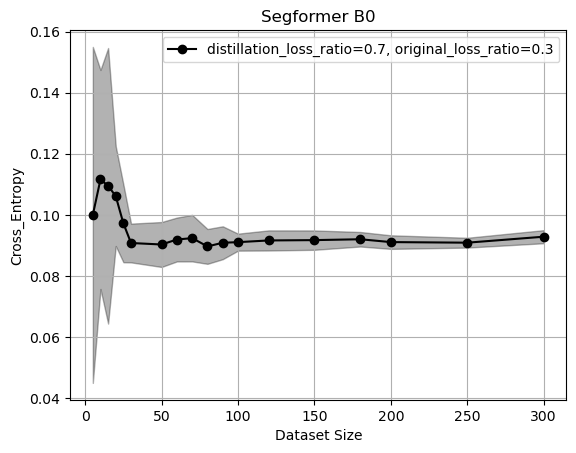

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()